# ARIMA model for predicting US Covid trend
ARIMA (autoregressive integrated moving average) is a statistical analysis model that uses time series data to either better understand the data set or to predict future trends. We will use this model to predict future values based on past values. Here, we focus on predicting the number of potential Covid cases up to 2 weeks ahead for the US.

### Read csv data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("../1_data_extraction/covid_final_cumulative.csv", parse_dates=[1])
df

,Country,Date,Confirmed,Deaths,Recovered
0,Afghanistan,2020-01-22,0,0,0.0
1,Afghanistan,2020-01-23,0,0,0.0
2,Afghanistan,2020-01-24,0,0,0.0
3,Afghanistan,2020-01-25,0,0,0.0
4,Afghanistan,2020-01-26,0,0,0.0
...,...,...,...,...,...
122409,Zimbabwe,2021-10-09,131762,4636,NaN
122410,Zimbabwe,2021-10-10,131796,4637,NaN
122411,Zimbabwe,2021-10-11,131875,4643,NaN
122412,Zimbabwe,2021-10-12,132016,4645,NaN


## Forecasting US cases
### 1) Plots

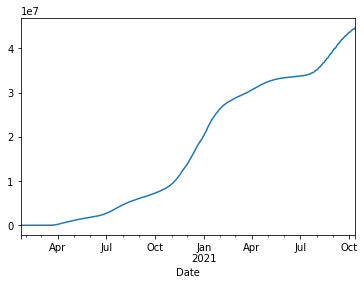

In [3]:
# Extract USA data
df = df[df['Country'] == "United States"]
usa = df.groupby('Date')['Confirmed'].sum()

# Change date to period datatype for modelling
usa.index = pd.DatetimeIndex(usa.index).to_period('D')

# Plot
usa.plot()
plt.show()

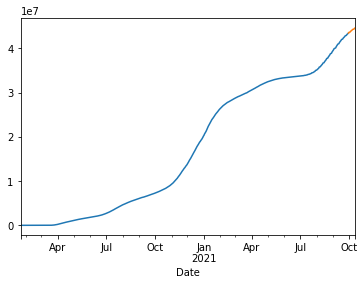

In [4]:
# Split train and test (test is the last 14 days)
usa_train = usa.loc[:'2021-09-30']
usa_test = usa.loc['2021-09-30':]

# Plot
fig, ax = plt.subplots()
usa_train.plot(ax=ax)
usa_test.plot(ax=ax)
plt.show()

### 2) Test if the data is stationary

In [5]:
from statsmodels.tsa.stattools import adfuller

In [6]:
# Time series data must be stationary for modelling
# The Augmented Dickey–Fuller Test (ADF) is used to test for stationarity
result = adfuller(usa)

# test statistic
result[0]

# p-value
result[1]

# Critical values
result[4]

{'1%': -3.4410103235939746,
 '5%': -2.866243374831338,
 '10%': -2.5692748053002195}

The p-value is >0.05, so we cannot reject the null hypothesis that the data is non-stationary. Differencing or transformation is needed to make data stationary. 

ADF Statistic: -2.1098456380028403
p-value: 0.24057409534782664


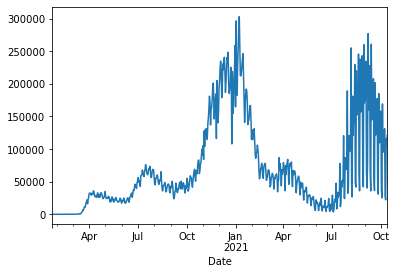

In [7]:
# Calculate the first difference of the time series
usa_stationary = usa.diff().dropna()

# Run ADF test on the differenced time series
result = adfuller(usa_stationary)

# Print the test statistic and the p-value
print('ADF Statistic:', result[0])
print('p-value:', result[1])

# Plot the differenced time series
fig, ax = plt.subplots()
usa_stationary.plot(ax=ax)
plt.show()

The p-value is still >0.05. Taking the second difference:

ADF Statistic: -4.238709716927843
p-value: 0.0005662389298468463


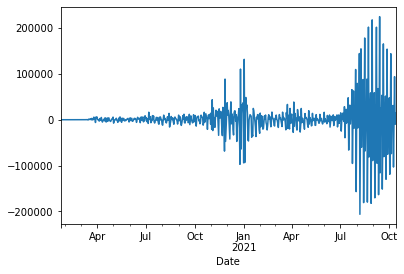

In [8]:
# Calculate the second difference of the time series
usa_stationary = usa.diff().diff().dropna()

# Run ADF test on the differenced time series
result = adfuller(usa_stationary)

# Print the test statistic and the p-value
print('ADF Statistic:', result[0])
print('p-value:', result[1])

# Plot the differenced time series
fig, ax = plt.subplots()
usa_stationary.plot(ax=ax)
plt.show()

The p-value is <0.05 so we will take the second difference. We will then plot the Autocorrelation function (ACF) and Partial Autocorrelation function (PACF) to determine possible orders for our ARIMA model. 

In [9]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

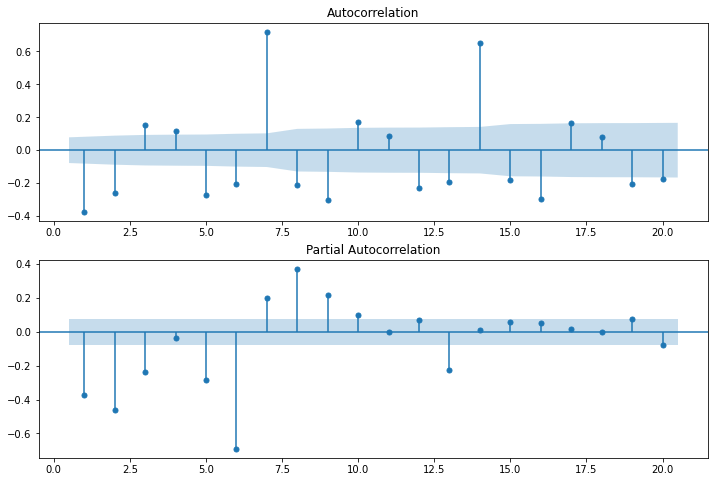

In [10]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))
 
# Plot the ACF of usa
plot_acf(usa_stationary, lags=20, zero=False, ax=ax1)

# Plot the PACF of usa
plot_pacf(usa_stationary, lags=20, zero=False, ax=ax2)

plt.show()

The ACF and PACF plots are inconclusive so we will conduct a search over different order values and assess the models based on the AIC (Akaike information criterion) and BIC (Bayesian information criterion). 

### 3) Search over model order using AIC and BIC

In [11]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [12]:
order_aic_bic=[]

for p in range(5):
    for q in range(5):
        try:
            # Create and fit ARMA(p,q) model
            model = SARIMAX(usa, order=(p,2,q), trend='c')
            results = model.fit()
            order_aic_bic.append((p, q, results.aic, results.bic))
        except:
            print(p, q, None, None)

order_df = pd.DataFrame(order_aic_bic, columns=['p', 'q', 'AIC', 'BIC'])

# Print order_df in order of increasing AIC
print(order_df.sort_values('AIC'))

# Print order_df in order of increasing BIC
print(order_df.sort_values('BIC'))

/Users/Mac/opt/anaconda3/envs/torch/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/Mac/opt/anaconda3/envs/torch/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/Mac/opt/anaconda3/envs/torch/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/Mac/opt/anaconda3/envs/torch/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimi

    p  q           AIC           BIC
18  3  3  14603.089584  14638.642634
23  4  3  14603.305076  14643.302258
24  4  4  14604.010637  14648.451950
19  3  4  14606.268427  14646.265608
14  2  4  14608.971409  14644.524459
13  2  3  14611.853543  14642.962461
9   1  4  14720.144105  14751.253024
8   1  3  14725.466425  14752.131213
4   0  4  14727.449208  14754.113995
17  3  2  14734.348023  14765.456942
3   0  3  14735.956010  14758.176666
11  2  1  14737.867192  14760.087848
21  4  1  14738.749545  14769.858464
16  3  1  14739.857316  14766.522104
12  2  2  14747.142566  14773.807353
7   1  2  14753.143166  14775.363822
2   0  2  14776.018380  14793.794905
1   0  1  14776.995714  14790.328107
6   1  1  14777.458718  14795.235243
15  3  0  14791.740839  14813.961495
20  4  0  14792.825317  14819.490104
10  2  0  14826.121757  14843.898282
22  4  2  14882.802775  14918.355825
5   1  0  14975.012505  14988.344899
0   0  0  15067.543400  15076.431662
    p  q           AIC           BIC
1

We choose a model with the lowest AIC value, therefore ARIMA(3,2,3) will be our selected model.

### 4) Model diagnostics

After selecting our model we will conduct some diagnoses to determine if it is a good model. 

In [13]:
# Fit model
model = SARIMAX(usa, order=(3,2,3))
results = model.fit()

# Calculate the mean absolute error from residuals
mae = np.mean(np.abs(results.resid))
mae # considering that there are so many cases each day, this error is not too bad

14266.029644549273

In [14]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Confirmed   No. Observations:                  631
Model:               SARIMAX(3, 2, 3)   Log Likelihood               -7293.687
Date:                Tue, 19 Oct 2021   AIC                          14601.375
Time:                        17:11:22   BIC                          14632.484
Sample:                    01-22-2020   HQIC                         14613.459
                         - 10-13-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1426      0.051     -2.820      0.005      -0.242      -0.043
ar.L2         -0.8613      0.024    -35.172      0.000      -0.909      -0.813
ar.L3          0.2543      0.049      5.181      0.000       0.158       0.350
ma.L1         -0.5638      0.045    -12.657      0.000      -0.651      -0.476
ma.L2          0.7252      0.021     33.972      0.000       0.683       0.767
ma.L3         -0.7200      0.032    -22.454      0.000      -0.783      -0.657
sigma2      8.875e+08    9.6e-12   9.25e+19      0.000    8.87e+08    8.87e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1531.15
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):              62.85   Skew:                             0.78
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.74e+35. Standard errors may be unstable.
"""

The Prob(Q) and Prob(JB) values are the p-values for the null hypothesis that residuals are uncorrelated and are normally distributed, respectively. Our results show that the residuals are uncorrelated (Prob(Q) = 0.95) but are not normally distributed (Prob(JB) = 0.00). The QQ plot below reinforces that the residuals are not normally distributed, which is not ideal, but we will continue using this model.

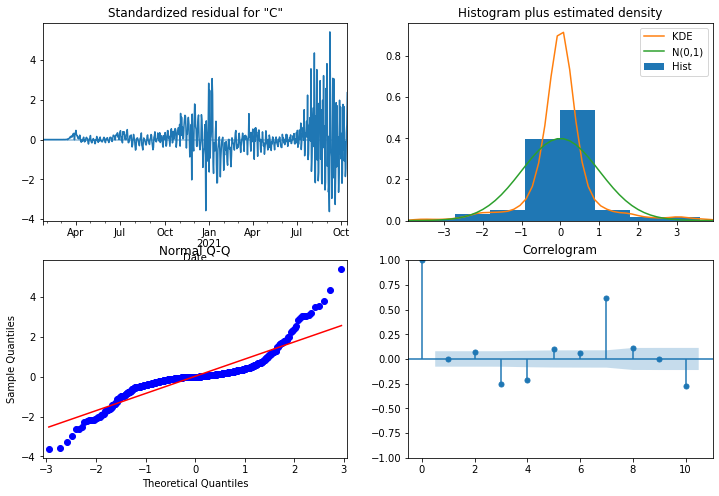

In [15]:
# Create the 4 diagostics plots
results.plot_diagnostics(figsize=(12,8))
plt.show()

### 5) Generate predictions for test set

We will make some predictions on the last 2 weeks of our data and compare our results to the test set.

In [16]:
# Generate predictions
one_step_forecast = results.get_prediction(start=-14)

# Extract prediction mean
mean_forecast = one_step_forecast.predicted_mean

# Get confidence intervals of predictions
confidence_intervals = one_step_forecast.conf_int()

# Select lower and upper confidence limits
lower_limits = confidence_intervals.loc[:,'lower Confirmed']
upper_limits = confidence_intervals.loc[:,'upper Confirmed']

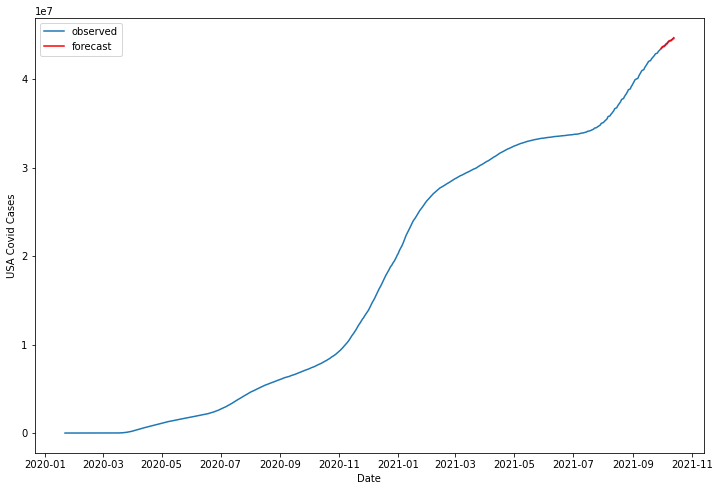

In [17]:
plt.figure(figsize=(12, 8))

# Plot USA data
plt.plot(usa.index.to_timestamp(), usa, label='observed')

# Plot mean predictions for last 2 weeks
plt.plot(mean_forecast.index, mean_forecast, color='r', label='forecast')

# Shade the area between your confidence limits
plt.fill_between(lower_limits.index, lower_limits, upper_limits, color='pink')

plt.xlabel('Date')
plt.ylabel('USA Covid Cases')
plt.legend()
plt.show()

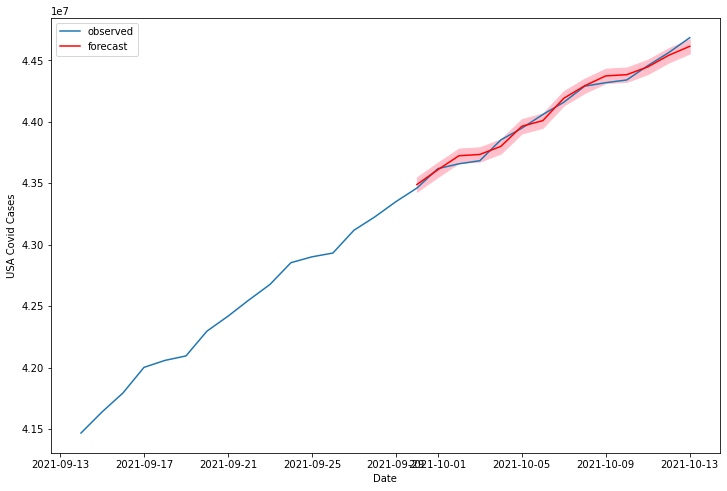

In [18]:
# Show a zoom in of the plot

plt.figure(figsize=(12, 8))

plt.plot(usa.index.to_timestamp()[-30:], usa[-30:], label='observed')

plt.plot(mean_forecast.index, mean_forecast, color='r', label='forecast')

plt.fill_between(lower_limits.index, lower_limits, upper_limits, color='pink')

plt.xlabel('Date')
plt.ylabel('USA Covid Cases')
plt.legend()
plt.show()

### 6) Forecast future values

In [19]:
# Make ARIMA forecast of next 2 weeks
two_week_forecast = results.get_forecast(steps=14)

forecast_mean = two_week_forecast.predicted_mean
confidence_intervals = two_week_forecast.conf_int()

lower_limits = confidence_intervals.loc[:,'lower Confirmed']
upper_limits = confidence_intervals.loc[:,'upper Confirmed']

The following graph is our prediction for the next two weeks into the future, including our 95% confidence intervals:

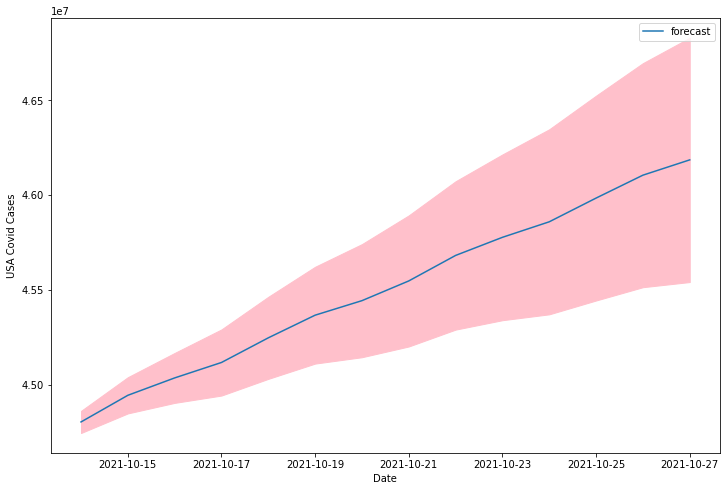

In [20]:
plt.figure(figsize=(12, 8))

plt.plot(forecast_mean.index.to_timestamp(), forecast_mean, label='forecast')

plt.fill_between(lower_limits.index, lower_limits, upper_limits, color='pink')

plt.xlabel('Date')
plt.ylabel('USA Covid Cases')
plt.legend()
plt.show()

#### Predicted US covid cumulative cases over the next 2 weeks:

In [21]:
forecast_mean

2021-10-14    4.480484e+07
2021-10-15    4.494528e+07
2021-10-16    4.503689e+07
2021-10-17    4.511826e+07
2021-10-18    4.524816e+07
2021-10-19    4.536756e+07
2021-10-20    4.544404e+07
2021-10-21    4.554803e+07
2021-10-22    4.568239e+07
2021-10-23    4.577781e+07
2021-10-24    4.585963e+07
2021-10-25    4.598464e+07
2021-10-26    4.610531e+07
2021-10-27    4.618594e+07
Freq: D, Name: predicted_mean, dtype: float64

#### 95% confidence intervals for predicted US covid cumulative cases over the next 2 weeks:

In [22]:
confidence_intervals

,lower Confirmed,upper Confirmed
2021-10-14,4.474645e+07,4.486323e+07
2021-10-15,4.484981e+07,4.504075e+07
2021-10-16,4.490527e+07,4.516852e+07
2021-10-17,4.494392e+07,4.529259e+07
2021-10-18,4.503184e+07,4.546449e+07
2021-10-19,4.511240e+07,4.562271e+07
2021-10-20,4.514590e+07,4.574218e+07
2021-10-21,4.520255e+07,4.589351e+07
2021-10-22,4.529144e+07,4.607334e+07
2021-10-23,4.534100e+07,4.621462e+07
